In [1247]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import scipy
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn
from addition_dataset import GroupAddition

In [440]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing results locally

In [1114]:
import addition_dataloader
import eval
from LSTM import LSTM

In [1115]:
b = 4
tables = all_tables[b]

In [1116]:
table = tables[((0, 0, 0, 0),
                (0, 0, 0, 0),
                (0, 0, 0, 0),
                (0, 0, 0, 0))]

In [1123]:
model = LSTM(b, 1)

In [1124]:
training_dataloader, testing_dataloader = addition_dataloader.prepare(b, 3, table, split_type='interpolate', split_ratio=0.8)

In [1125]:
losses, training_accs, testing_accs = eval.eval(model, training_dataloader, testing_dataloader, num_passes=1000)

t = 0
loss = 1.487686, training_acc = 0.038, testing_acc = 0.000

t = 100
loss = 0.744530, training_acc = 0.173, testing_acc = 0.167

t = 200
loss = 0.434393, training_acc = 0.654, testing_acc = 0.583

t = 300
loss = 0.168394, training_acc = 0.846, testing_acc = 0.667

t = 400
loss = 0.177703, training_acc = 0.769, testing_acc = 0.917

t = 500
loss = 0.397277, training_acc = 0.827, testing_acc = 0.833

t = 600
loss = 0.032955, training_acc = 0.981, testing_acc = 0.917

t = 700
loss = 0.109868, training_acc = 0.923, testing_acc = 0.833

t = 800
loss = 0.060462, training_acc = 0.865, testing_acc = 1.000

t = 900
loss = 0.047138, training_acc = 0.981, testing_acc = 0.833



## Results from jobs

In [1164]:
with open('../pickles/learning_metrics4.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

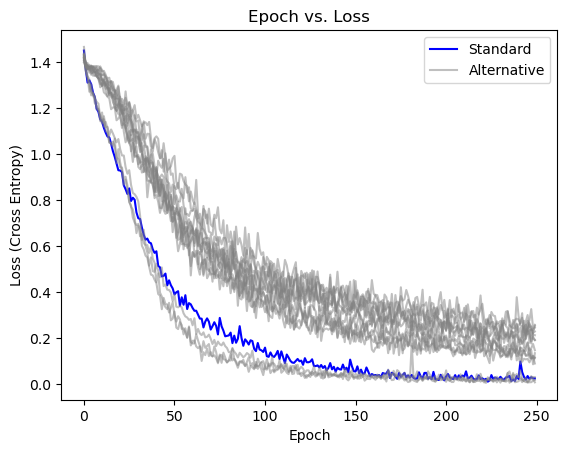

In [1147]:
for dc in learning_metrics.keys():
    loss = learning_metrics[dc]['loss']
    if (np.array(dc) == 0).all():
        plt.plot(loss, color='blue', label='Standard')
    else:
        plt.plot(loss, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.show()

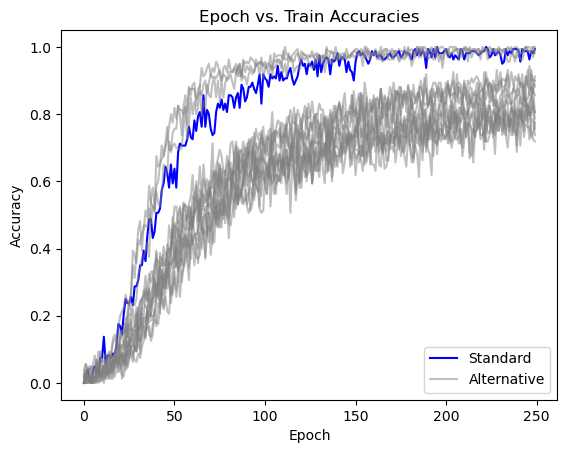

In [1148]:
for dc in learning_metrics.keys():
    train_acc = learning_metrics[dc]['training_acc']
    if (np.array(dc) == 0).all():
        plt.plot(train_acc, color='blue', label='Standard')
    else:
        plt.plot(train_acc, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Train Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

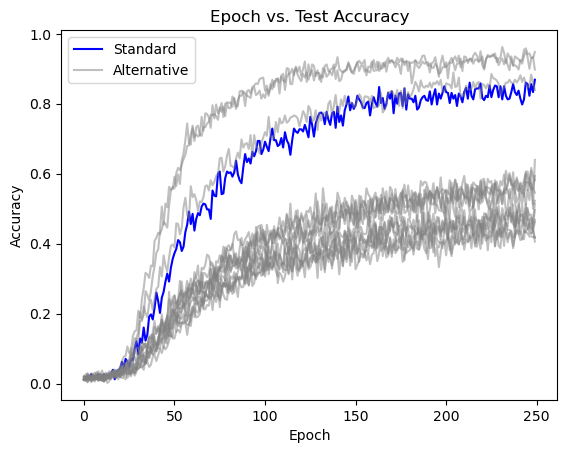

In [1162]:
for dc in learning_metrics.keys():
    test_acc = learning_metrics[dc]['testing_acc']
    if (np.array(dc) == 0).all():
        plt.plot(test_acc, color='blue', label='Standard')
    else:
        plt.plot(test_acc, alpha=0.5, color='grey', label='Alternative')
plt.legend(labels=['Standard', 'Alternative'])
plt.title(f'Epoch vs. Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Correlate with box-counting dimension

In [1074]:
with open('../pickles/est_dim_box_vs_depth.pickle', 'rb') as f:
    est_dim_box_vs_depth = pickle.load(f)

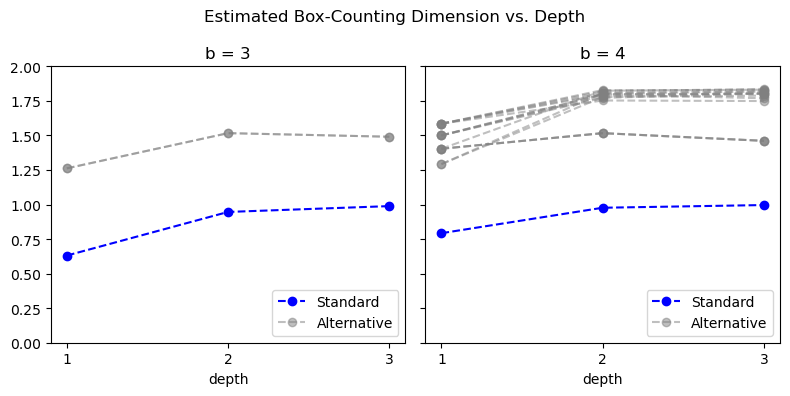

In [1093]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for i in range(len(axes)):
    ax = axes[i]
    tables = all_tables[i+3]
    for dc in tables.keys():
        if (np.array(dc) == 0).all():
            ax.plot(est_dim_box_vs_depth[i+3][dc], color='blue', marker='o', linestyle='--', label='Standard')
        else:
            ax.plot(est_dim_box_vs_depth[i+3][dc], alpha=0.5, color='grey', marker='o', linestyle='--', label='Alternative')
        ax.set_xticks([0, 1, 2], [1, 2, 3])
        ax.set_xlabel('depth')
        ax.set_yticks(np.linspace(0, 2, 9))
    if (i == 3):
        ax.set_ylabel('est. box-counting dim.')
    ax.set_title('b = '+str(i+3))
    ax.legend(labels=['Standard', 'Alternative'], loc='lower right')
fig.suptitle('Estimated Box-Counting Dimension vs. Depth')
plt.tight_layout()

In [1213]:
def acc(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

In [1215]:
x = np.arange(250)
y = learning_metrics[dc]['testing_acc']
(a, b, c), cov = curve_fit(acc, x, y)

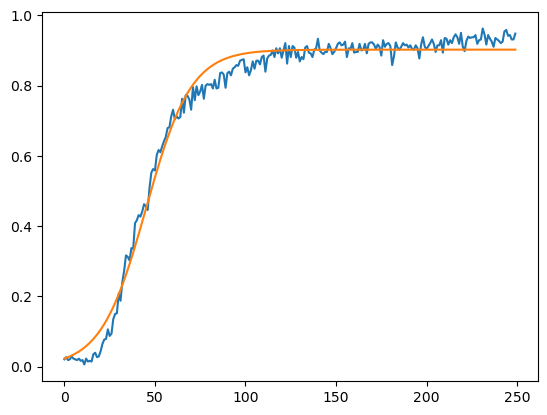

In [1216]:
plt.plot(y)
plt.plot(acc(x, a, b, c))

In [1248]:
with open('../pickles/all_tables_d1.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [1249]:
all_est_dims = []
all_critical_pts = []

for b in range(3, 5):
    x = np.arange(250)
    with open(f'../pickles/learning_metrics{b}.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    est_dims = [est_dim_box_vs_depth[b][dc][2] for dc in all_tables[b].keys()]
    critical_pts = []
    for dc in all_tables[b].keys():
        y = learning_metrics[dc]['testing_acc']
        (a, b, c), cov = curve_fit(acc, x, y)
        critical_pts.append(c)
    all_est_dims += est_dims
    all_critical_pts += critical_pts

Text(0, 0.5, 'critical point of sigmoid fit')

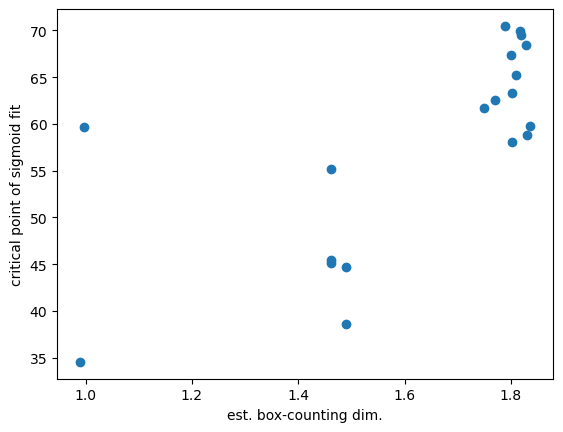

In [1250]:
plt.scatter(all_est_dims, all_critical_pts)
# plt.xticks(np.linspace(0, 2, 9))
# plt.yticks(np.linspace(0, 250, 6))
plt.xlabel('est. box-counting dim.')
plt.ylabel('critical point of sigmoid fit')

In [1251]:
scipy.stats.spearmanr(all_est_dims, all_critical_pts)

SignificanceResult(statistic=0.621539962663237, pvalue=0.0045004040234716556)